In [1]:
using Omega
using Images
using POMDPs
using POMDPModelTools
using POMDPSimulators
using StaticArrays
using Parameters
using Random
using MCTS
import UnicodePlots
using DiscreteValueIteration
using Plots: plot, histogram2d
import StatsPlots
import Plots

export runmodel, N, S, E, terraincostsmat, plotmigration

nsamples = 100;

Consider a migration dispute between three hypothetical island nations:
$S$ to the South, $E$ to the East and $N$ to the North.
The government of $S$ aims to reduce emigration of its population to the $N$, and considers constructing a barrier between $S$ and $N$.

We model this problem as counterfactional inference in a Markov Decision Process (MDP) model.
To determine whether the border can be effective:
- We will assume members of the population are rational: that they migrate according to their beliefs about the world and their objectives.
- We will condition on observed migration patterns to infer a posterior belief over the population objectives.
- In this conditional model, we consider the intervention (adding the barrier) and predict the resulting migration.

Concretely, we assume the world is a 7 by 6 grid and a world population of 1000 residents.
gridworld.jl defines `SimpleGridWorld` an MDP which we will construct and solve for each member of the population using POMDPs

In [2]:
include("gridworld.jl")
include("plots.jl")

makeplots (generic function with 1 method)

### The model

Each `Terrain` cell is either land, water, or wall

In [3]:
"Piece of land, water or wall"
struct Terrain
  id::Int
  pos::Vector{GWPos}
end

Main.##385.Terrain

Each citizen of this universe receives cost at every time step of their life
This cost is subjective to that individual and depends on the terrain

In [4]:
"Encodes `cost` of existing in `Terrain` for a single time step"
struct CostTerrain
  obj::Terrain
  cost::Float64
end

Main.##385.CostTerrain

Islands: South, North, East

In [5]:
const S = Terrain(1, [GWPos(2,1), GWPos(3, 1), GWPos(4, 1), GWPos(3,2)])
const N = Terrain(2, [GWPos(3,4), GWPos(2, 5), GWPos(3, 5), GWPos(4,5), GWPos(3,6)])
const E = Terrain(3, [GWPos(7,2), GWPos(6, 3), GWPos(7,3), GWPos(7,4)])
const islands = (S, N, E);

Wall is another kind of terrain (that is hard to cross)

In [6]:
const wall = Terrain(4, [GWPos(1,3), GWPos(2,3), GWPos(3,3), GWPos(4,3), GWPos(5,3),
                         GWPos(1,4), GWPos(1, 5), GWPos(1, 6),
                         GWPos(5,4), GWPos(5, 5), GWPos(5, 6)])
# We'll assume that the cost of being in water or traversing a wall is constant among the population
const watercost = -10.0
const wallcost = -30

-30

Construct an inverse map from position to the terrain type

In [7]:
const invmap = Dict()
for ter in [S, N, E, wall]
  for pos in ter.pos
    invmap[pos] = ter
  end
end

"Rewards Dict from positions to values"
function rewards(objects, defaultcost = watercost)
  rewards_ = Dict{GWPos, Float64}()
  for obj in objects
    for xy in obj.obj.pos
      if xy in keys(rewards_)
        rewards_[xy] += obj.cost
      else
        rewards_[xy] = obj.cost
      end
    end
  end
  rewards_
end

const HIGH =  10.0
const NEUTRAL = 0.0
const LOW = -10.0

-10.0

`terraincostmat` maps where a person is born to their beliefs about all other natiosn

In [8]:
const terraincostsmat = [normal(LOW, 3.0) normal(NEUTRAL, 3.0) normal(HIGH, 3.0);
                         normal(LOW, 3.0) normal(HIGH, 3.0) normal(LOW, 3.0);
                         normal(NEUTRAL, 3.0) normal(NEUTRAL, 3.0) normal(NEUTRAL, 3.0)]
# terraincostsmatrv = constant(terraincostsmat)
const terraincostsmatrv = randarray(terraincostsmat)
const addwall = constant(false)

"Simulate migration for one citizen"
function createmdp(ω; size = (7,6), defrward = watercost,
                       rng = MersenneTwister(12345))
  # Sample the island of birth uniformly along islands
  birthisland = rand(rng, [islands...])
  # Within the country sample a birth position
  birthplace_ = rand(rng, birthisland.pos)
  terraincostsmat_ = terraincostsmatrv(ω)
  # Construct a belief about the world: i.e. costs of every terrain for this person
  objects = [CostTerrain(obj, terraincostsmat_[birthisland.id, obj.id]) for obj in islands]
  # Potentially add the wall to their set of beleifs
  if addwall(ω)
    push!(objects, CostTerrain(wall, wallcost))
  end
  # objects = [CostTerrain(obj, terraincosts[(birthisland, obj)](ω)) for obj in islands]
  # Construct a reward function
  rewards_ = rewards(objects)
  for (k, v) in rewards_
    rewards_[k] += randn(rng)
  end
  # Construct an mdp
  mdp = SimpleGridWorld(size = size,
                        rewards = rewards_,
                        defreward = defrward,
                        initialstate = birthplace_,
                        tprob = 0.99,
                        terminate_from = Set{GWPos}())
end

function actions_(mdp; solver = ValueIterationSolver(max_iterations=10, belres=1e-6),
                      rng = MersenneTwister(12345),
                      nsteps = 10)
  # Solve the mdp to construct a policy
  policy = solve(solver, mdp) # runs value iterations
  # Act according to the policy for 10 time steps
  states = GWPos[]
  for (s, a, r) in stepthrough(mdp, policy, "s,a,r", max_steps = nsteps; rng = rng)
    push!(states, s)
  end
  states
end

"Sequences of states traversed by all `npeople` people"
function statesseqs(ω, npeople = 100, rng  = Random.MersenneTwister(12345))
  statesseqs_ = Vector{GWPos}[]
  for i = 1:npeople
    mdp = createmdp(ω; rng = rng)
    actionseq = actions_(mdp; rng = rng)
    push!(statesseqs_, actionseq)
  end
  statesseqs_
end

"return[i][j] is total amount of time people born in region i spent in region j"
function migrationmatrix(allseqs)
  mat = zeros(length(islands), length(islands) + 2)
  for stateseq in allseqs
    birth = invmap[stateseq[1]]
    for state in stateseq
      terr = get(invmap, state, 0)
      if terr == 0
        mat[birth.id, 5] += 1.0
      else
        mat[birth.id, terr.id] += 1.0
      end
    end
  end
  mat
end

Main.##385.migrationmatrix

`statesseqs_` is a random variable over actions that an individual takes

In [9]:
const statesseqs_ = ciid(statesseqs)

function migrationmat_(ω)
  samples = statesseqs_(ω)
  allstates = vcat(samples...)
  xs, ys = ntranspose(allstates)
  migrationmatrix(samples)
end

migrationmat_ (generic function with 1 method)

`migrationmat` is a random variable over migration matrices

In [10]:
const migrationmat = ciid(migrationmat_)

81:Main.##385.migrationmat_()::Array{Float64,2}

### Conditional model
Suppose we observe migration behaviour, what does that tell us about their beliefs
First lets's plot some samples from the prior

┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`

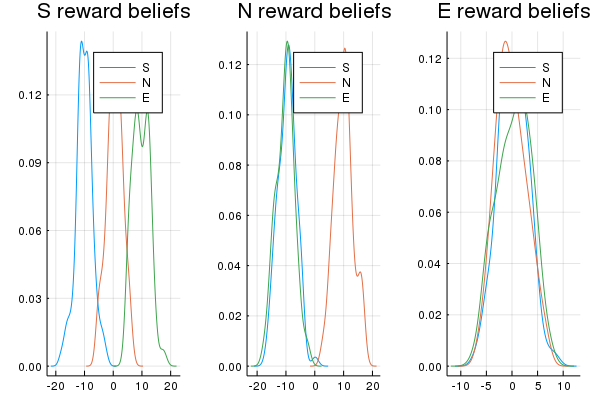

In [11]:
beliefsamples = rand(terraincostsmatrv, nsamples)
plt1 = plotbeliefs(destructure(beliefsamples, 1), title = "S reward beliefs")
plt2 = plotbeliefs(destructure(beliefsamples, 2), title = "N reward beliefs")
plt3 = plotbeliefs(destructure(beliefsamples, 3), title = "E reward beliefs")
plot(plt1, plt2, plt3, layout = (1, 3))

We can consider the posterior beliefs if we were to observe a migration matrix

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To use: `Pkg.add("StatsPlots"); using StatsPlots`
└ @ Plots /home/zenna/.julia/packages/Plots/47Tik/src/args.jl:1055
┌ Warning: seriestype density has been moved to StatsPlots.  To

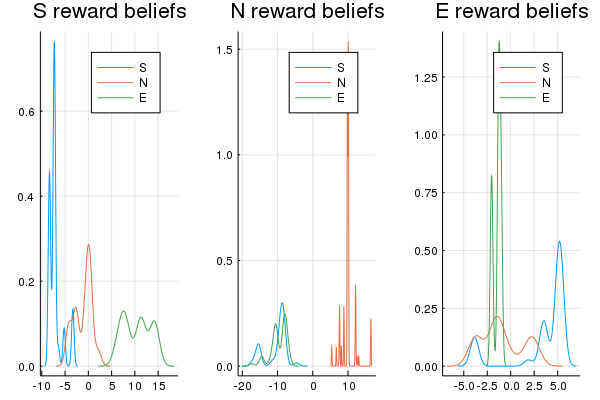

In [12]:
const obs_migrationmat =  [ 74.0    0.0  185.0   0.0  111.0
                            0.0  350.0    0.0   0.0    0.0
                            143.0    0.0   51.0  22.0   64.0]
const terraincostsmatrv_cond = cond(terraincostsmatrv, migrationmat ==ₛ obs_migrationmat)
condmigrationmat, cond_beliefsamples = ntranspose(rand((migrationmat, terraincostsmatrv_cond), nsamples; alg = Replica))
plt1 = plotbeliefs(destructure(cond_beliefsamples, 1), title = "S reward beliefs")
plt2 = plotbeliefs(destructure(cond_beliefsamples, 2), title = "N reward beliefs")
plt3 = plotbeliefs(destructure(cond_beliefsamples, 3), title = "E reward beliefs")
plot(plt1, plt2, plt3, layout = (1, 3))

Let's show a migration matrix

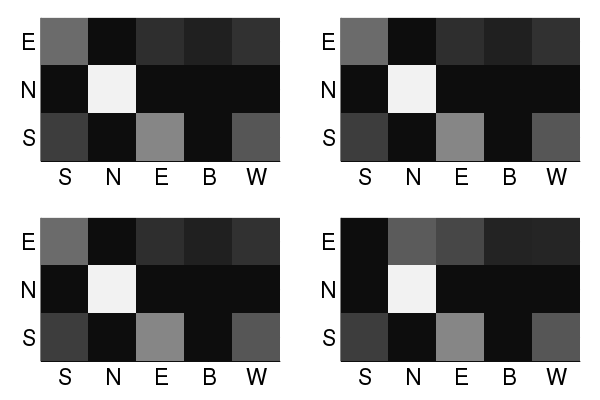

In [13]:
plots = [plotmigration(x, false) for x in rand(condmigrationmat, 4)]
plot(plots..., layout = (2, 2))

### Counterfactual
Now we can consider the counterfactual: Given that we haev observed migration patterns,
how would they be different if we had built a barrier?

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]


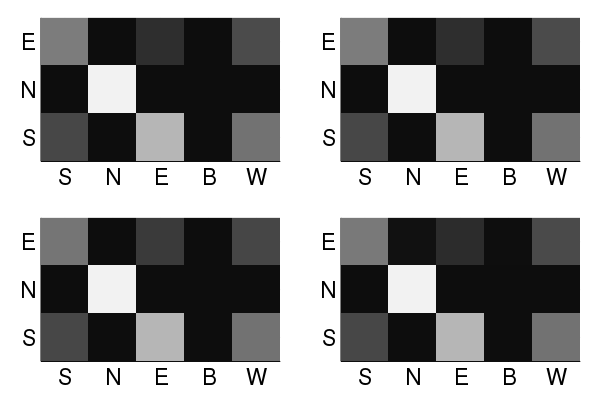

In [14]:
const intervened = replace(cond(migrationmat, migrationmat ==ₛ obs_migrationmat), addwall => true)
migrationsamples = rand(intervened, nsamples; alg = Replica)
plots = [plotmigration(x, false) for x in rand(migrationsamples, 4)]
plot(plots..., layout = (2, 2))

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*